# JAM FITTER

In [1]:
import sys,os
from fitlab.resman import RESMAN
from fitlab.mcsamp import MCSAMP
from tools.config import load_config,conf
from tools.tools import load, save,checkdir
import pylab as py
import numpy as np
import pandas as pd
import copy
def lprint(msg):
    sys.stdout.write('\r')
    sys.stdout.write('%s' %msg)
    sys.stdout.flush()
%matplotlib inline

## generate excel file for the new data

Lets open one the excel files in the database

To do the simulation one needs to create an xlsx file with columns as shown above. You can prepare an xlsx file outside of the program and save the file in the same place as the notebook

For the purpose of illustration, we will create the xlsx file from here

## data sets 

In [2]:
conf['datasets']={}

### HERMES data

In [14]:
conf['datasets']['sidis']={}
conf['datasets']['sidis']['filters']={0:{'idx':None,'filter':None}}
 
conf['datasets']['sidis']['filters'][0]['idx']=[9000]
conf['datasets']['sidis']['filters'][0]['filter']="z<0.6 and Q2>1.69 and pT>0.2 and pT<0.9"
conf['datasets']['sidis']['xlsx']={}

conf["datasets"]["sidis"]["xlsx"][9000]="notebooks/9000.xlsx"  #   for EIC simulation 

conf['datasets']['sidis']['norm']={}
for k in conf['datasets']['sidis']['xlsx']: 
    conf['datasets']['sidis']['norm'][k]={'value':1,'fixed':True,'min':0,'max':1} 

## parameters

In [10]:
conf['params']={}
conf['shape']=1

### TMD PDF/FF parameters (from upol analysis)

In [11]:
conf['params']={}
conf['params']['pdf']={}
conf['params']['pdf']['widths0 valence']  = {'value':5.89294556274006398056e-01,'fixed':True,'min':0,'max':1}
conf['params']['pdf']['widths0 sea']      = {'value':6.33443286558464269120e-01,'fixed':True,'min':0,'max':1}
conf['params']['ff']={}
conf['params']['ff']['widths0 pi+ fav']   = {'value':1.15920500644793311729e-01,'fixed':True,'min':0,'max':1}
conf['params']['ff']['widths0 pi+ unfav'] = {'value':1.39782079427820671302e-01,'fixed':True,'min':0,'max':1}

##  Simulation

### initialize fitpack libraries

In [16]:
conf['resman'] = RESMAN()
mcsamp=MCSAMP()

loading sidis data sets 9000
multiprocess setup: ncpus=1 / observable
ERR: exp=9000 obs=M_EIC and target=proton not implemented


SystemExit: 

### collect results from global analysis

MC=mcsamp.get_MC_samples('results/mcdata')

In [13]:
path2results='sidis_upol'
MC=mcsamp.get_MC_samples(path2results+'/mcdata')

runs max likelihoods
166.863761757
166.863761739
166.897132816
166.863761726
166.863761652
166.863761805
166.863761702
166.86376168
167.036694104
166.863761759
166.863761785
166.863761691
166.863761858
23.3323051903
23.3323051906
23.3323052366
23.3323052365
23.3323052568
23.3323052147
23.3323052352
23.3323052232
23.3323052014
23.3323052083
166.863761669
166.863761657
166.879094962
166.863761692
166.863761749
166.863761754
166.863761788
166.863761785
166.863761748
166.863761831
166.863761835
166.863761812
166.863761786
166.863761816
166.863761836
166.863761719
166.863761743
sample  size= 14350
sample2 size= 2307


### estimate central values and uncertainties

In [17]:
imax=np.argmax(MC['weights2'])
params=np.einsum('i,ik',MC['weights2'],MC['samples2'])
dparams2=[(sample-params)**2 for sample in MC['samples2']]
dparams=np.einsum('i,ik',MC['weights2'],dparams2)**0.5

In [18]:
for i in range(len(params)):
    print '%10s = %f'%(conf['parman'].order[i][2],params[i])

IndexError: list index out of range

ValueError: x must be 1D or 2D

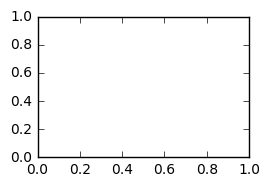

In [19]:
samples=MC['samples']
samples2=MC['samples2']
weights=MC['weights']
weights2=MC['weights2']
order=MC['order']
runs=MC['runs']

nrows,ncols=2,2
fig = py.figure(figsize=(ncols*3,nrows*2))

def get_idx(key,tag):
    for i in range(len(order)):
        if order[i][1]==key and order[i][2]==tag:
            return i

global cnt
cnt=0
def plot(tags):
    global cnt
    for i in range(1,len(tags)):
        cnt+=1
        if tags[i]==None: continue
        idx=get_idx(tags[0],tags[i])
        ax=py.subplot(nrows,ncols,cnt)
        vmin=np.amin(samples2.T[idx])
        vmax=np.amax(samples2.T[idx])
        R=(vmin,vmax)
        for k in runs:
            ax.hist(runs[k]['samples'].T[idx],weights=runs[k]['weights'],bins=50,normed=True,range=R)
        ax.hist(samples.T[idx],weights=weights,bins=50,color='k',normed=True,range=R)
        ax.hist(samples2.T[idx],weights=weights2,bins=50,color='r',histtype='step',normed=True,range=R)
        ax.set_title(tags[i])
        mean=np.einsum('i,i',samples2.T[idx],weights2)
        std=np.einsum('i,i',(samples2.T[idx]-mean)**2,weights2)**0.5
        print '%20s = %10.5f +/- %10.5f'%(tags[i],mean,std)
        #ax.set_xlim(vmin,vmax)
    py.tight_layout()

plot(['pdf','widths0 valence','widths0 sea'])
plot(['ff','widths0 pi+ fav','widths0 pi+ unfav'])



## compute prediction for new data

In [20]:
data={'weights':MC['weights2']}
cnt=0
for s in MC['samples2']:
    cnt+=1    
    lprint('%d/%d'%(cnt,len(MC['samples2'])))  
    conf['resman'].get_residuals(s);
    for k in conf['resman'].lnres.tabs:
        if k!=5000: continue
        if k  not in data: data[k]=[]
        thy=conf['resman'].lnres.tabs[k]['thy']    
        data[k].append(thy)

3583/3583

In [21]:
for k in data: data[k]=np.array(data[k])
thy,dthy={},{}
for k in data:
    if k=='weights': continue
    thy[k]=np.einsum('i,ik->k',data['weights'],data[k])
    dthy[k]=np.einsum('i,ik->k',data['weights'],(data[k]-thy[k])**2)**0.5
for k in thy: 
    conf['resman'].lnres.tabs[k]['thy']=copy.copy(thy[k])
    conf['resman'].lnres.tabs[k]['dthy']=copy.copy(dthy[k])

In [99]:
#resman.get_residuals(params);

In [22]:
tab=conf['ln tabs'][5000]
tab['value']=tab['thy']
tab['stat_u']=0.01*tab['thy']
tab=pd.DataFrame(tab)
tab

,N,Q2,Shift,alpha,col,dthy,kT2max,obs,r-residuals,residuals,shift,stat_u,tar,thy,value,x,xL,xpi,y
0,1.0,10,0.0,0.0,EIC,6.938894e-17,0.04,F2LN,0.0,-inf,0.0,0.000192,p,0.019183,0.019183,0.002,0.9,0.02,0.1
1,1.0,10,0.0,0.0,EIC,2.428613e-17,0.04,F2LN,0.0,-inf,0.0,0.000167,p,0.016702,0.016702,0.004,0.9,0.04,0.1
2,1.0,10,0.0,0.0,EIC,1.734723e-18,0.04,F2LN,0.0,-inf,0.0,0.000154,p,0.015445,0.015445,0.006,0.9,0.06,0.1
3,1.0,10,0.0,0.0,EIC,6.938894e-18,0.04,F2LN,0.0,-inf,0.0,0.000146,p,0.014622,0.014622,0.008,0.9,0.08,0.1
4,1.0,10,0.0,0.0,EIC,1.734723e-18,0.04,F2LN,0.0,-inf,0.0,0.000140,p,0.014029,0.014029,0.010,0.9,0.10,0.1


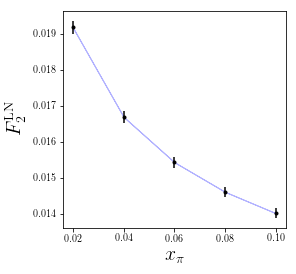

In [23]:
nrows,ncols=1,1
fig = py.figure(figsize=(ncols*4,nrows*4))
ax=py.subplot(111)
ax.errorbar(tab['xpi'],tab['value'],yerr=tab['stat_u'],fmt='k.')
ax.fill_between(tab['xpi'],tab['thy']-tab['dthy'],tab['thy']+tab['dthy'],color='b',alpha=0.3)

ax.set_ylabel(r'$F_2^{\rm LN}$',size=20)
ax.set_xlabel(r'$x_{\pi}$',size=20)

Notice that the above curve include the uncertainties on $F_2^{\rm LN}$ from LN+DY data. Since the uncertainties on $F_2^{\rm LN}$ are smaller  than the simulated 1% uncertainties, we expect this data to provide no further constraint    

### overwrite the xlsx file

In [ ]:
data=pd.DataFrame(tab)
writer=pd.ExcelWriter('5000.xlsx')
data.to_excel(writer,'sheet1')
writer.save() 

## Comments

In this notebook we've generated a pseudo data (labeled 5000) by writing the kinematics values directly on the cell. If you have many bins to construct the pseudo data set, you can upload from the Homepage an excel file with all the kinematics. Make sure you have the same format as in this tutorial
